## Notebook 4 : Trends and forecasts of property values 

## 1 - Introduction ##

Overview of the notebook’s objective and the data used.


this notebook will help identifying the past trends and foresee the evolution of the property values. We will base this analysis on historical data. Retrospective analysis : How did the prices evolve throughout time ? Can we target global  and seasonal trends ? What would be the prices in 3, 5 or 10 years ? Those insights can be more robust by linking them to geographical comparisons.

Nous allons nous poser différentes questions pour mieux saisir le contexte :
- Comment les valeurs foncières ont-elles évolué de 2019 à 2024 ?
- Quelle régions ou types de biens ont montré une croissance ou un déclin ?
- Peut-on prédire les tendances futures des valeurs foncières ?


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

In [25]:
# Read in the data
df_tf = pd.read_csv('df_complete.csv', low_memory=False)

In [26]:
df_clean = df_tf[
    (df_tf['Valeur fonciere'] > 1000) & 
    (
        (df_tf['Surface reelle bati'] > 0) & (df_tf['Nombre pieces principales'] > 0) |(df_tf['Surface terrain']>10) |
        (df_tf['Type local'].isin(['Maison','Appartement','Local industriel. commercial ou assimilé','Dépendance']))
    )
]

drop_columns=['Voie', 'Code commune', 'Code type local','Nombre de lots']
df_clean=df_clean.drop(columns=drop_columns, errors='ignore')



In [27]:
#### CONVERTS TO THE RIGHT TYPE ####
category_convert = ['Nature mutation', 'Code postal', 'Commune', 'Code departement', 'Type local']
df_clean[category_convert] = df_clean[category_convert].astype('category')

df_clean['Date mutation'] = pd.to_datetime(df_clean['Date mutation'], errors = 'coerce')
df_clean['Date mutation'] = df_clean['Date mutation'].interpolate(method='linear')

df_clean['Valeur fonciere']=df_clean['Valeur fonciere'].replace({'\xa0':'',',':'.'}, regex=True)
df_clean['Valeur fonciere']=pd.to_numeric(df_clean['Valeur fonciere'], errors='coerce')
df_clean['Mois'] = df_clean['Date mutation'].dt.month
df_clean['Annee'] = df_clean['Date mutation'].dt.year
df_clean['Jour'] = df_clean['Date mutation'].dt.day

#df_clean.info()
#print(df_clean[['Date mutation', 'Mois', 'Annee']].head())

In [28]:
missing_values = df_clean.isnull().sum()
(df_clean == 0).sum()


Date mutation                       0
Nature mutation                     0
Valeur fonciere                     0
Code postal                       733
Commune                             0
Code departement                    0
Type local                          0
Surface reelle bati           9941436
Nombre pieces principales    10502109
Surface terrain               4788614
annee                               0
Mois                                0
Annee                               0
Jour                                0
dtype: int64

In [29]:
#### CHECK DUPLICATES ####
df_clean.drop_duplicates(keep='last', inplace=True)
df_clean.duplicated().sum()

0

## 2 - Methodology ##

Explanation of the analysis methods and visualizations.

Data Exploration:
- Analyze the evolution of property values over time (by year).
- Identify significant periods of increase or decrease in prices.

In [30]:
print(df_clean.describe(include='all'))
print(df_clean[['Valeur fonciere', 'Surface reelle bati', 'Surface terrain']].describe())

                        Date mutation Nature mutation  Valeur fonciere  \
count                        16534589        16534589     1.653459e+07   
unique                            NaN               6              NaN   
top                               NaN           Vente              NaN   
freq                              NaN        15999177              NaN   
mean    2021-12-18 23:53:26.117276160             NaN     5.879374e+05   
min               2019-01-07 00:00:00             NaN     1.000250e+03   
25%     2020-10-19 02:10:54.545454592             NaN     6.750000e+04   
50%               2021-12-07 00:00:00             NaN     1.550000e+05   
75%               2023-03-02 00:00:00             NaN     2.820000e+05   
max               2024-12-06 00:00:00             NaN     1.415000e+10   
std                               NaN             NaN     9.786668e+06   

        Code postal   Commune Code departement Type local  \
count    16534589.0  16534589         16534589   1

In [31]:
high_values = df_clean[df_clean['Valeur fonciere'] > 1e6]
high_value_properties_sorted = high_values.sort_values('Valeur fonciere', ascending=False)


### Outliers ###

In [98]:
import numpy as np
Q1 = df_clean['Valeur fonciere'].quantile(0.25)
Q3 = df_clean['Valeur fonciere'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean['Valeur fonciere log'] = df_clean['Valeur fonciere'].apply(lambda x: np.log(x + 1))  # +1 pour éviter log(0)

outliers = df_clean[(df_clean['Valeur fonciere'] < lower_bound) | 
                    (df_clean['Valeur fonciere'] > upper_bound)]
outliers.groupby(['Annee', 'Type local'])['Valeur fonciere'].agg(['count', 'mean', 'std'])


/var/folders/sr/6t4rh27j1v1fr55gfr9fvsv40000gn/T/ipykernel_3979/897154010.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outliers.groupby(['Annee', 'Type local'])['Valeur fonciere'].agg(['count', 'mean', 'std'])


count          mean  \
Annee Type local                                                       
2019  0                                          43787  3.376175e+06   
      Appartement                                28978  6.266510e+06   
      Dépendance                                  9128  2.385278e+06   
      Local industriel. commercial ou assimilé   16095  8.595511e+06   
      Maison                                     19530  2.460268e+06   
2020  0                                          71525  3.105441e+06   
      Appartement                                44080  6.791387e+06   
      Dépendance                                 18914  2.166889e+06   
      Local industriel. commercial ou assimilé   23660  7.944146e+06   
      Maison                                     36060  2.034605e+06   
2021  0                                          95423  4.259888e+06   
      Appartement                                55867  1.511380e+07   
      Dépendance                                 52038  4.389085e+06   
      Local industriel. commercial ou assimilé   30002  8.085356e+06   
      Maison                                     55943  5.001090e+06   
2022  0                                         104347  3.789077e+06   
      Appartement                                58022  2.184188e+07   
      Dépendance                                 63137  3.389220e+06   
      Local industriel. commercial ou assimilé   32813  8.122447e+06   
      Maison                                     59265  4.226761e+06   
2023  0                                          86548  2.845686e+06   
      Appartement                                55311  5.938177e+06   
      Dépendance                                 78092  4.237877e+06   
      Local industriel. commercial ou assimilé   29919  6.655407e+06   
      Maison                                     43902  1.584113e+06   
2024  0                                          31212  2.451795e+06   
      Appartement                                14774  3.850468e+06   
      Dépendance                                 16858  1.414274e+06   
      Local industriel. commercial ou assimilé    9555  5.367842e+06   
      Maison                                     14982  1.444827e+06   

                                                         std  
Annee Type local                                              
2019  0                                         1.069031e+07  
      Appartement                               2.002437e+07  
      Dépendance                                1.068140e+07  
      Local industriel. commercial ou assimilé  3.546680e+07  
      Maison                                    8.190843e+06  
2020  0                                         1.424528e+07  
      Appartement                               2.216418e+07  
      Dépendance                                9.111500e+06  
      Local industriel. commercial ou assimilé  3.224512e+07  
      Maison                                    1.046255e+07  
2021  0                                         1.987987e+07  
      Appartement                               4.785404e+07  
      Dépendance                                2.454654e+07  
      Local industriel. commercial ou assimilé  1.431447e+08  
      Maison                                    2.571891e+07  
2022  0                                         2.093872e+07  
      Appartement                               7.480935e+07  
      Dépendance                                2.514133e+07  
      Local industriel. commercial ou assimilé  3.492667e+07  
      Maison                                    2.966694e+07  
2023  0                                         8.471319e+06  
      Appartement                               1.824820e+07  
      Dépendance                                1.094979e+07  
      Local industriel. commercial ou assimilé  2.949326e+07  
      Maison                                    4.143393e+06  
2024  0                                    

#### Stock des valeurs outliers ####

D'autre part, nous créeons un Data Frame qui exclut les outliers, un autre Data Frame qui inclut les outliers seulement.

In [99]:
median_value = df_clean['Valeur fonciere'].median()
df_wo_outliers= df_clean.copy()
df_clean['Valeur fonciere'] = np.where(df_clean['Valeur fonciere'] > upper_bound, upper_bound, df_clean['Valeur fonciere'])
df_clean['Valeur fonciere'] = np.where(df_clean['Valeur fonciere'] < lower_bound, lower_bound, df_clean['Valeur fonciere'])

### 1. Comment les valeurs foncières et le volume des transactions ont-ils évolué de 2019 à 2024 ? ###

#### 1.1 Analyse du volume des transactions ####

En chiffre, voici l'évolution du nombre de transactions réalisées de 2019 à 2024. On constate donc une augmentation et un pic du volume de transactions en 2022, et une baisse les années suivantes.

In [100]:
# Statistiques descriptives des colonnes temporelles
df_clean[['Mois', 'Annee', 'Jour']].describe()
df_clean['Annee-Mois'] = df_clean['Date mutation'].dt.to_period('M')

# Nombre d'observations par mois et par année pour observer les tendances
observations_par_mois = df_clean['Annee-Mois'].value_counts().sort_index()
observations_par_annee = df_clean['Annee'].value_counts().sort_index()

#print(observations_par_mois)
print(observations_par_annee)

Annee
2019    1621704
2020    2917672
2021    3768840
2022    3725110
2023    3247216
2024    1254047
Name: count, dtype: int64


Le graphique ci-dessous représente l'évolution par mois et année des mutations immobilières de 2019 à 2024, par types de biens : appartements, maisons, dépendances et locaux industriels, commerciaux ou assimilés. Il permet de mettre en évidence des tendances saisonnières, des différences entre les catégories de biens, et d'identifier l’impact d’événements externes sur le volume global des transactions.

###### Choisissez la plage temporelle et le type de biens que vous souhaitez observer ######

In [101]:
mutations_analyse=df_clean.copy()
mutations_analyse['Date mutation'] = pd.to_datetime(mutations_analyse['Date mutation'])
mutations_analyse['Annee'] = mutations_analyse['Date mutation'].dt.year
mutations_analyse['Annee-Mois'] = mutations_analyse['Date mutation'].dt.to_period('M').astype(str)

def plot_interactive(annee_range, type_bien=None):
    filtered_data = mutations_analyse[
        (mutations_analyse['Annee'] >= annee_range[0]) & 
        (mutations_analyse['Annee'] <= annee_range[1])
    ]
    
    if type_bien: 
        filtered_data = filtered_data[filtered_data['Type local'] == type_bien]
    
    sequences = (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)
        .size()
        .reset_index(name='count')
    )

    plt.figure(figsize=(20, 6))
    sns.lineplot(
        data=sequences,
        x='Annee-Mois', y='count',
        hue='Type local', marker='o', palette='Set2'
    )
    plt.title('Évolution des transactions par Mois et Année')
    plt.xlabel('Temps (Année-Mois)')
    plt.ylabel('Nombre de Transactions')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Type de Bien')
    plt.show()

annee_widget = widgets.IntRangeSlider(
    value=[2021, 2023],
    min=2019, max=2024, step=1,
    description='Années :',
    continuous_update=False
)

type_bien_widget = widgets.Dropdown(
    options=[None] + list(mutations_analyse['Type local'].unique()),
    value=None,
    description="Type de Bien :"
)

interact(
    plot_interactive, 
    annee_range=annee_widget, 
    type_bien=type_bien_widget,
    show_median=widgets.Checkbox(value=True, description="Afficher Médiane"),
    show_mean=widgets.Checkbox(value=False, description="Afficher Moyenne")
)


interactive(children=(IntRangeSlider(value=(2021, 2023), continuous_update=False, description='Années :', max=…

<function __main__.plot_interactive(annee_range, type_bien=None)>

##### Le graphique comporte : #####
- En abscisses les mois et années de janvier 2019 à décembre 2024 pour illustrer une progression temporelle continue. Il est toutefois possible de modifier la plage de la période à observer.
- En ordonnées le nombre de transactions immobilières réalisées chaque mois.
- Différentes courbes, chacune représentant un type de local.

Nous observons un pattern saisonnier en termes de volume des transactions, quelle que soit la catégorie du bien. 
On peut identifier une augmentation régulière des transactions en début d'années, notamment pour les années 2020 à 2023. Cette augmentation intervient souvent vers janvier-février. Par la suite, le volume atteint un pic, généralement lors de la période estivale, c'est-à-dire autour de juin-juillet. Enfin, une baisse progressive a lieu en fin d'année, à partir de septembre.

On peut noter que les maisons et appartements ont une forte demande car ils répondent aux besoins essentiels d'habitation, tandis que les locaux industriels ont un public restreint et répondent à des besoins spécifiques. Ceci explique son marché moins dynamique. Cette demande croissante pour des logements individuels peut s'expliquer dans un contexte post-Covid où le télétravail a rendu les besoins d'espaces et de confort plus importants, également par le type d'acheteurs (les familles).

À partir de 2021, on constate une évolution intéressante : les dépendances commencent à dépasser les appartements en volume de transactions. Cette tendance s'accentue jusqu’en octobre 2023, où les dépendances prennent même le lead sur les maisons, devenant la catégorie avec le plus de transactions.
L'évolution des taux d'intérêt pourrait avoir une incidence sur l'évolution des transaction immobilières, en particulier les dépendances. En effet,d'après l'Observatoire Crédit Logement, le taux du crédit immobilier est passé de 1.06% à 4.24%, de mars 2022 à décembre 2023, avant de redescendre à 3.46%. Face à cette augmentation du taux d'intérêt, les dépendances offrent un compromis entre prix d'achat plus bas et possibilité de créer ou d'aménager un espace, en maintenant des mensualités. 

Nous allons examiner comment les moyennes et les médianes des valeurs foncières ont changé annuellement et mensuellement pendant cette période.

#### 1.1 Évolution annuelle et mensuelle des valeurs foncières ####

Cette première analyse nous permettra d'examiner l'évolution des valeurs foncières annuelles en termes de moyenne et de médiane. Il s'agit de comprendre les tendances générales et l'évolution du marché immobilier dans cette période.

Nous avons ci-dessous un graphique qui trace l'evolution globale de la médiane et la moyenne des valeurs foncières de 2019 à 2024. 

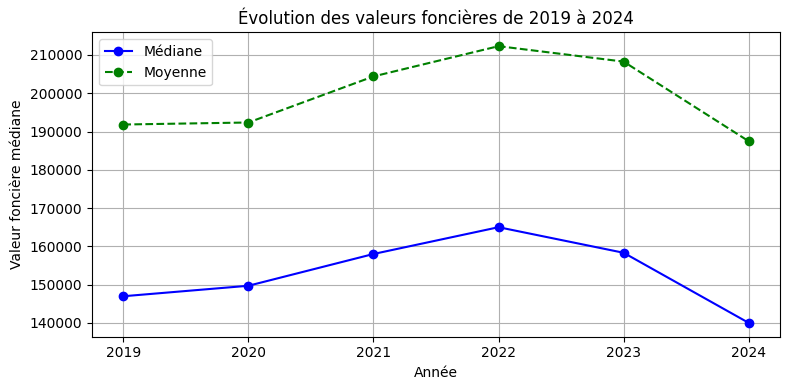

In [102]:
# Calcul de la médiane et de la moyenne par année
median_peryear = df_clean.groupby('Annee')['Valeur fonciere'].median().reset_index()
mean_peryear = df_clean.groupby('Annee')['Valeur fonciere'].mean().reset_index()
def plot_evolution_valeurs():
    plt.figure(figsize=(8, 4))
    plt.plot(median_peryear['Annee'], median_peryear['Valeur fonciere'], marker='o', label='Médiane', color='blue')
    plt.plot(mean_peryear['Annee'], mean_peryear['Valeur fonciere'], marker='o', label='Moyenne', color='green', linestyle='--')

    plt.title('Évolution des valeurs foncières de 2019 à 2024')
    plt.xlabel('Année')
    plt.ylabel('Valeur foncière médiane')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_evolution_valeurs()

La médiane est la valeur centrale dans une distribution. 50% des valeurs sont en dessous et 50% sont au-dessus. Cela la rend moins sensibles aux outliers (valeurs extrêmes). En revanche, la moyenne est plus influencée par les valeurs extrêmes ou abberantes. 

Nous observons une stagnation de la médiane de la valeur foncière entre 2021 et 2023, ce qui suggère que la majorité des transactions ont maintenu des prix relativement constants sur cette période. 

Cependant, on observe une augmentation de la moyenne à partir de 2020 jusqu'à atteindre un pic significatif en 2022, suggérant qu'il y a eu des transactions exceptionnelles cette année-là, avec des propriétés de haute valeur vendues à des prix bien supérieures à la moyenne. Ce phénomène pourrait être le résultat de quelques ventes immobilières de luxe ou dans des quartiers spécifiques, mais aussi des raisons économiques et politiques, notamment le COVID-19 apparu fin 2020, ce qui a pu influencé des personnes à acheter.



##### Statistiques #####

L'interprétation des statistiques des prix fonciers permet d'obtenir des insights sur l'évolution du marché de l'immobilier. Ci-dessous est affiché un tableau présentant la moyenne (mean), la médiane (median) et l'écart-type (std) pour chaque année étudiée.



In [103]:
annual_stats = df_clean.groupby('Annee')['Valeur fonciere'].agg(['mean', 'median', 'std']).reset_index()
annual_stats


,Annee,mean,median,std
0,2019,191826.299879,146960.000,169541.739845
1,2020,192353.926940,149700.000,167169.452653
2,2021,204392.572242,158000.000,173917.177549
3,2022,212296.762048,165000.000,178297.631851
4,2023,208261.601164,158315.305,181538.368971
5,2024,187460.301474,140000.000,173063.392976


#### Zoom sur les prix moyens des transactions foncières par année ####

- 2019 : 583 892 €
- 2020 : 527 950 € (- 55 942 € soit -9,58%)
- 2021 : 874 665 € (+ 346 715 € soit +65,65%)
- 2022 : 1 061 206 € (+ 186 541 € soit +21,33%)
- 2023 : 647 887 € (- 413 319 € soit -38,95%)
- 2024 : 393 298 € (- 254 589 € -39,31%)

En 2021, la moyenne des valeurs foncières augmente fortement (+65,65%) par rapport à 2020. Cela peut être lié à une reprise économique post-Covid et à une  demande significative sur le marché immobilier notamment avec le télétravail.

Ci-dessous, nous montrons la différence entre la médiane et la moyenne chaque année. Nous pouvons observer clairement que les outliers ont un impact considérable dans la valeur foncière par année.

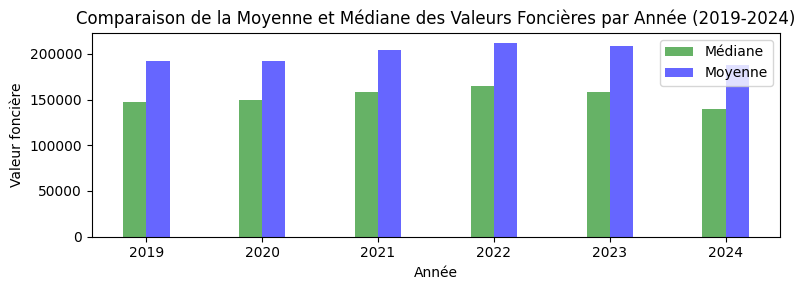

In [104]:
def plot_comparaison_moyenne_médiane():
    plt.figure(figsize=(8, 3))
    # Placer la médiane et la moyenne côte à côte
    x = mean_peryear['Annee']
    offset = 0.1 
    plt.bar(x - offset, median_peryear['Valeur fonciere'], width=offset * 2, label='Médiane', color='green', alpha=0.6)
    plt.bar(x + offset, mean_peryear['Valeur fonciere'], width=offset * 2, label='Moyenne', color='blue', alpha=0.6)
    plt.title('Comparaison de la Moyenne et Médiane des Valeurs Foncières par Année (2019-2024)')
    plt.xlabel('Année')
    plt.ylabel('Valeur foncière')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparaison_moyenne_médiane()


#### Zoom sur les écarts-type des transactions foncières par année ####

L'écart-type permet de mesurer la dispersion des valeurs autour de la moyenne. Les variations sont particulièrement marquées en 2021 et 2022, avec un écart-type respectif de 18 914 710 € et 14 568 680 €.

Pour expliquer pourquoi l'écart-type est aussi élevé, il est nécessaire d'explorer les causes potentielles de cette dispersion.

Nous allons analyser les outliers (valeurs extrêmes) de 2021 et 2022, par type de bien : 

- Appartements : 
La moyenne en 2021 est de 15 113 800€ avec un écart-type de 47 854 040€.

In [105]:
outliers_2021 = outliers[outliers['Annee'] == 2021]
most_exp_2021 = outliers_2021.sort_values(by='Valeur fonciere', ascending=False).iloc[0]
print("Bien le plus cher parmi les outliers en 2021 :")
most_exp_2021

Bien le plus cher parmi les outliers en 2021 :


Date mutation                           2021-07-14 08:43:38.181818112
Nature mutation                                                 Vente
Valeur fonciere                                         14149999600.0
Code postal                                                   13008.0
Commune                                                MARSEILLE 8EME
Code departement                                                   13
Type local                   Local industriel. commercial ou assimilé
Surface reelle bati                                            3604.0
Nombre pieces principales                                         0.0
Surface terrain                                                5484.0
annee                                                            2021
Mois                                                                7
Annee                                                            2021
Jour                                                               14
Annee-Mois          

In [106]:
outliers_2022 = outliers[outliers['Annee'] == 2022]
most_exp_2022 = outliers_2022.sort_values(by='Valeur fonciere', ascending=False).iloc[0]
print("\nBien le plus cher parmi les outliers en 2022 :")
most_exp_2022


Bien le plus cher parmi les outliers en 2022 :


Date mutation                2022-02-11 00:00:00
Nature mutation                            Vente
Valeur fonciere                      722590020.0
Code postal                              59700.0
Commune                         MARCQ EN BAROEUL
Code departement                              59
Type local                            Dépendance
Surface reelle bati                          0.0
Nombre pieces principales                    0.0
Surface terrain                            383.0
annee                                       2022
Mois                                           2
Annee                                       2022
Jour                                          11
Annee-Mois                               2022-02
Valeur fonciere log                    20.398353
Name: 11276013, dtype: object

Nous avons décidé d'afficher l'évolution des valeurs foncières par mois pour chaque année, de 2019 à 2024, indépendamment des types de local.

In [88]:
def plot_interactive(annee_range, show_median=True, show_mean=True):
    # Filtrer les données par plage d'années et de mois
    filtered_data = mutations_analyse[
        (mutations_analyse['Annee'] >= annee_range[0]) & 
        (mutations_analyse['Annee'] <= annee_range[1])
    ]    
    
    # Calcul des moyennes et des médianes pour la période et le type de bien filtrés
    prix_moyens = (
        filtered_data.groupby(['Annee-Mois'])['Valeur fonciere']
        .mean()
        .reset_index(name='mean_price')
    )
    
    prix_medians = (
        filtered_data.groupby(['Annee-Mois'])['Valeur fonciere']
        .median()
        .reset_index(name='median_price')
    )

    # Graphique de la moyenne et de la médiane
    plt.figure(figsize=(20, 6))
    
    if show_mean:
        sns.lineplot(
            data=prix_moyens,
            x='Annee-Mois', y='mean_price',
            label='Moyenne', marker='o', color='blue'
        )
        
    if show_median:
        sns.lineplot(
            data=prix_medians,
            x='Annee-Mois', y='median_price',
            label='Médiane', marker='o', color='orange'
        )
    
    plt.title('Évolution des Prix par Mois et Année')
    plt.xlabel('Temps (Année-Mois)')
    plt.ylabel('Prix (€)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='Statistiques')
    plt.show()

annee_widget = widgets.IntRangeSlider(
    value=[2019, 2023],
    min=2019, max=2024, step=1,
    description='Années :',
    continuous_update=False
)

interact(
    plot_interactive, 
    annee_range=annee_widget, 
    show_median=widgets.Checkbox(value=True, description="Afficher Médiane"),
    show_mean=widgets.Checkbox(value=True, description="Afficher Moyenne")
)

interactive(children=(IntRangeSlider(value=(2019, 2023), continuous_update=False, description='Années :', max=…

<function __main__.plot_interactive(annee_range, show_median=True, show_mean=True)>

In [41]:
def plot_interactive(annee_range, type_bien='Maison', show_median=True, show_mean=True):
    filtered_data = mutations_analyse[
        (mutations_analyse['Annee'] >= annee_range[0]) & 
        (mutations_analyse['Annee'] <= annee_range[1])
    ]
    
    if type_bien: 
        filtered_data = filtered_data[filtered_data['Type local'] == type_bien]
    
    sequences = (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)
        .size()
        .reset_index(name='count')
    )
    
    prix_moyens = (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)['Valeur fonciere']
        .mean()
        .reset_index(name='mean_price')
    )

    prix_medians= (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)['Valeur fonciere']
        .median()
        .reset_index(name='median_price')
    )

    plt.figure(figsize=(20, 6))
    if show_mean:
        sns.lineplot(
        data=prix_moyens,
        x='Annee-Mois', y='mean_price',
        hue='Type local', marker='o', palette='viridis'
    )
        
    if show_median:
        sns.lineplot(
        data=prix_medians,
        x='Annee-Mois', y='median_price',
        hue='Type local', marker='o', palette='Set2'
    )
    
    plt.title('Évolution des Prix par Mois et Année')
    plt.xlabel('Temps (Année-Mois)')
    plt.ylabel('Prix (€)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

annee_widget = widgets.IntRangeSlider(
    value=[2021, 2023],
    min=2019, max=2024, step=1,
    description='Années :',
    continuous_update=False
)

type_bien_widget = widgets.Dropdown(
    options=list(mutations_analyse['Type local'].unique()),
    value=None,
    description="Type de Bien :"
)

interact(
    plot_interactive, 
    annee_range=annee_widget, 
    type_bien=type_bien_widget,
    show_median=widgets.Checkbox(value=True, description="Afficher Médiane"),
    show_mean=widgets.Checkbox(value=False, description="Afficher Moyenne")
)


interactive(children=(IntRangeSlider(value=(2021, 2023), continuous_update=False, description='Années :', max=…

<function __main__.plot_interactive(annee_range, type_bien='Maison', show_median=True, show_mean=True)>

In [80]:
from statsmodels.tsa.seasonal import STL

# Exemple de décomposition avec STL
data = df_clean.groupby('Date mutation')['Valeur fonciere'].median()
stl = STL(data, seasonal=13)
result = stl.fit()
result.plot()
plt.show()


ValueError: Unable to determine period from endog

## 3 - Results ##

Presentation of the analyses, visualizations, and findings.

Visualizations:
- Time series graphs showing property value trends over the years.
- Line charts comparing trends across different regions.

## 4 - Conlusion and recommandations ##

Summary of discoveries and investment advice.

Conclusions:
- Synthesize observed price trends over the past years.
- Identify external factors that could explain changes (e.g., economy, demographics, infrastructure).

Recommendations:
- Propose investment recommendations based on future price forecasts (e.g., investing in regions with predicted price growth).
- Risk management advice based on past and future property value trends.